### io.tif check

In [1]:
import os
from hybrid.io import read_tiff_stack, write_tiff_stack

In [2]:
DATA_DIR = os.path.abspath("./data")  # это notebooks/data
file_name = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
path = os.path.join(DATA_DIR, file_name)


In [4]:
stack = read_tiff_stack(path, normalize_mode="none", dtype=None)
print("Shape:", stack.shape, "dtype:", stack.dtype, "min:", stack.min(), "max:", stack.max())


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
Shape: (1951, 800, 768) dtype: uint16 min: 476 max: 3070


In [6]:
stack_norm = read_tiff_stack(path, normalize=True)  # это триггерит percentile-нормализацию (legacy-режим), ок
print("Normalized:", stack_norm.shape, stack_norm.dtype, stack_norm.min(), stack_norm.max())

[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
Normalized: (1951, 800, 768) float32 0.0 1.0


In [8]:
import numpy as np
from hybrid.io import write_tiff_stack

# save raw stack as float32 BigTIFF with compression
out_raw = os.path.join(DATA_DIR, "test_raw_float.tiff")
write_tiff_stack(out_raw, stack, dtype="float32", bigtiff=True, compress=True)


### filters.dog check

In [10]:
# --- DoG end-to-end check on full stack (CPU/GPU + progress) ---

# короткие импорты (после обновлённого __init__.py в io/filters)
from hybrid.io import read_tiff_stack, write_tiff_stack
from hybrid.filters import dog_bandpass
import os

# ---- конфиг теста ----
DATA_DIR  = os.path.abspath("./data")                        # notebooks/data (игнорится гитом)
file_name = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
path      = os.path.join(DATA_DIR, file_name)

SIGMA_LOW  = 1.2
SIGMA_HIGH = 14.0
DEVICE     = "auto"     # "auto" | "cpu" | "gpu"

# 1) читаем сырой стек (float32, без нормализации)
stack = read_tiff_stack(path, normalize=False)
print("RAW:", stack.shape, stack.dtype, "min:", float(stack.min()), "max:", float(stack.max()))

# 2) читаем нормализованный стек (legacy percentile → [0,1])
stack_norm = read_tiff_stack(path, normalize=True)
print("NORM:", stack_norm.shape, stack_norm.dtype, "min:", float(stack_norm.min()), "max:", float(stack_norm.max()))

# 3) DoG по всему потоку (с прогрессом и авто-GPU)
dog = dog_bandpass(
    stack_norm,
    sigma_low=SIGMA_LOW,
    sigma_high=SIGMA_HIGH,
    device=DEVICE,
    progress=True,
)
print("DoG :", dog.shape, dog.dtype, "mean:", float(dog.mean()), "std:", float(dog.std()))

# 4) Сохранения в notebooks/data
# 4a) честные данные DoG в float32 (BigTIFF + компрессия)
out_dog_float = os.path.join(DATA_DIR, "check_dog_stack_float32.tiff")
write_tiff_stack(out_dog_float, dog, dtype="float32", bigtiff=True, compress=True)

# 4b) версия для просмотра: нормализация в [0,1] ПОКАДРОВО и uint16
import numpy as np
dog_min = dog.min(axis=(1,2), keepdims=True).astype(np.float32)
dog_ptp = (dog.max(axis=(1,2), keepdims=True) - dog_min).astype(np.float32)
dog_ptp = np.clip(dog_ptp, 1e-6, None)
dog_u01 = ((dog - dog_min) / dog_ptp).astype(np.float32, copy=False)

out_dog_u16 = os.path.join(DATA_DIR, "check_dog_stack_uint16.tiff")
write_tiff_stack(out_dog_u16, dog_u01, dtype="uint16")

print("Saved:", out_dog_float)
print("Saved:", out_dog_u16)


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
RAW: (1951, 800, 768) uint16 min: 476.0 max: 3070.0
[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
NORM: (1951, 800, 768) float32 min: 0.0 max: 1.0
[GPU-auto] CuPy available → using GPU backend for DoG
DoG (GPU): 100%|██████████████████████████████████████████████████████████████████| 1951/1951 [00:12<00:00, 157.76it/s]
DoG : (1951, 800, 768) float32 mean: -1.3935627825312213e-11 std: 0.012763625010848045
Saved: D:\Projects\hybrid\notebooks\data\check_dog_stack_float32.tiff
Saved: D:\Projects\hybrid\notebooks\data\check_dog_stack_uint16.tiff


### filters.flatfield check

In [11]:
# 1) Imports
import numpy as np
import os
from hybrid.io import read_tiff_stack, write_tiff_stack
from hybrid.filters import estimate_flatfield, apply_flatfield  # GPU-aware versions

# конфиг
DATA_DIR  = os.path.abspath("./data")                    # notebooks/data
file_name = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
path      = os.path.join(DATA_DIR, file_name)

SIGMA_PX  = 60.0        # 40–80 px обычно ок
DEVICE    = "auto"      # "auto" | "cpu" | "gpu"
RENORM    = "robust"    # альтернатива: "none"

In [12]:
# 1) читаем сырой стек (без нормализации)
stack = read_tiff_stack(path, normalize=False)
print("RAW:", stack.shape, stack.dtype, "min:", float(stack.min()), "max:", float(stack.max()))


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
RAW: (1951, 800, 768) uint16 min: 476.0 max: 3070.0


In [13]:
# 2) оцениваем flat-field (на GPU, если доступно)
flat = estimate_flatfield(stack, sigma_px=SIGMA_PX, device="auto")
print("flat:", flat.shape, flat.dtype, "min/max/mean:",
      float(flat.min()), float(flat.max()), float(flat.mean()))

[GPU-auto] CuPy available → using GPU backend
flat: (800, 768) float32 min/max/mean: 0.6431958675384521 1.3211777210235596 1.0000001192092896


In [14]:
# 3) применяем flat-field: (a) для просмотра/MC (robust [0..1]), (b) в нативном масштабе (float32)
movie_ff_robust = apply_flatfield(stack, flat, renormalize="robust", device="auto")
movie_ff_native = apply_flatfield(stack, flat, renormalize="none",   device="auto")

print("ff_robust:", movie_ff_robust.shape, movie_ff_robust.dtype,
      "min/max:", float(movie_ff_robust.min()), float(movie_ff_robust.max()))
print("ff_native:", movie_ff_native.shape, movie_ff_native.dtype,
      "min/max:", float(movie_ff_native.min()), float(movie_ff_native.max()))

[GPU-auto] CuPy available → using GPU backend
[GPU-auto] CuPy available → using GPU backend
ff_robust: (1951, 800, 768) float32 min/max: 0.0 1.0
ff_native: (1951, 800, 768) float32 min/max: 740.0545043945312 3257.77734375


In [15]:
# 4) сохраняем артефакты в notebooks/data
# 4a) визуализация самого поля (uint16, отрезаем хвосты для просмотра)
import numpy as np
flat_vis = (np.percentile(flat, 99.5) and flat).clip(0, np.percentile(flat, 99.5))
flat_vis = (flat_vis / (flat_vis.max() + 1e-8)).astype(np.float32)

write_tiff_stack(os.path.join(DATA_DIR, "flat_vis.tiff"),
                 flat_vis[None], dtype="uint16")

# 4b) стек после коррекции для просмотра / MC → uint16
write_tiff_stack(os.path.join(DATA_DIR, "movie_ff_robust_uint16.tiff"),
                 movie_ff_robust, dtype="uint16", bigtiff=True, compress=True)

# 4c) стек после коррекции в нативном масштабе → float32 BigTIFF (для последующей обработки)
write_tiff_stack(os.path.join(DATA_DIR, "movie_ff_native_float32.tiff"),
                 movie_ff_native, dtype="float32", bigtiff=True, compress=True)

# 📂 Обзор промежуточных файлов (TIFF)

## Исходные данные
- **`MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff`**  
  Исходный raw movie без обработки.  

- **`test_raw_float.tiff`**  
  Raw movie в формате `float32` для удобства дальнейшей обработки.  

- **`test_norm.tiff`**  
  Raw movie, нормализованный в диапазон [0..1] (для быстрых sanity-проверок).  

---

## 🟢 DoG-фильтрация (Difference of Gaussians)
- **`check_dog_raw.tiff`**  
  Один кадр после DoG-фильтрации, **без нормализации**. Видно подавление фона.  

- **`check_dog.tiff`**  
  Тот же кадр после DoG, но нормализованный в [0..1].  
  Зернистый вид = нормальный эффект высокочастотного фильтра.  

---

## 🟡 Flat-field correction (коррекция неравномерности освещения)
- **`flat_vis.tiff`**  
  Карта освещённости (flatfield), полученная как медианный кадр, сглаженный гауссом.  
  Белый центр = эффект виньетирования.  

- **`movie_ff_native.tiff`**  
  Фильм после коррекции освещённости, в `float32`, **без нормализации**.  
  Используется для количественных шагов (например, ΔF/F).  

- **`movie_ff_robust.tiff`**  
  Фильм после коррекции освещённости, дополнительно нормализованный в [0..1].  
  Удобен для просмотра и motion correction.  

---

## 🔵 Sanity-check
- **`sanity_flat.tiff`**  
  Альтернативная визуализация карты освещённости (тот же flatfield, сохранён иначе).  

- **`sanity_ff_robust.tiff`**  
  То же, что и `movie_ff_robust.tiff`, но получено в sanity-блоке.  
  Отличий по сути нет.  

---


### mc.pwgrid check

In [1]:
# === Sanity-check for pwrigid_movie (CPU vs GPU) ===
import os
import time
import numpy as np

from hybrid.io import read_tiff_stack, write_tiff_stack
from hybrid.mc import pwrigid_movie

# ---------- CONFIG ----------
DATA_DIR = os.path.abspath("./data")  # run from notebooks/
IN_NAME  = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
path = os.path.join(DATA_DIR, IN_NAME)

tiles    = (3, 4)
overlap  = 24
upsample = 10

# ---------- LOAD (robust reader: memmap → RAM(if fits) → staging) ----------
movie_src = read_tiff_stack(
    path,
    normalize_mode="none",
    dtype=None,          # keep source dtype (likely uint16)
    # method="auto",     # default, shown for clarity
)
print(f"Loaded: shape={movie_src.shape}, dtype={movie_src.dtype}")

# pwrigid works in float; convert just-in-time
movie_f32 = movie_src.astype(np.float32, copy=False)

# ---------- CPU run ----------
t0 = time.time()
res_cpu = pwrigid_movie(
    movie=movie_f32,
    tiles=tiles,
    overlap=overlap,
    upsample=upsample,
    device="cpu",
    progress=True,
)
t_cpu = time.time() - t0
print(f"[CPU] {t_cpu/60:.2f} min | mean corr={res_cpu.mean_corr_after:.6f}")

out_cpu = path.replace(".tiff", "_pwrigid_CPU_f32.tiff")
# Save memmap-friendly (no compression) for fast downstream steps
write_tiff_stack(out_cpu, res_cpu.corrected, dtype="float32", compress=False)
print("Saved CPU result ->", out_cpu)

# ---------- GPU run (if available) ----------
try:
    import cupy as cp
    has_gpu = cp.cuda.runtime.getDeviceCount() > 0
except Exception:
    has_gpu = False

if has_gpu:
    t0 = time.time()
    res_gpu = pwrigid_movie(
        movie=movie_f32,
        tiles=tiles,
        overlap=overlap,
        upsample=upsample,
        device="gpu",
        progress=True,
    )
    t_gpu = time.time() - t0
    print(f"[GPU] {t_gpu/60:.2f} min | mean corr={res_gpu.mean_corr_after:.6f}")

    out_gpu = path.replace(".tiff", "_pwrigid_GPU_f32.tiff")
    write_tiff_stack(out_gpu, res_gpu.corrected, dtype="float32", compress=False)
    print("Saved GPU result ->", out_gpu)
else:
    print("No GPU available, skipping GPU run.")


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
Loaded: shape=(1951, 800, 768), dtype=uint16
pw-rigid MC (CPU): 100%|███████████████████████████████████████████████████████████| 1951/1951 [22:40<00:00,  1.43it/s]
[CPU] 22.93 min | mean corr=0.979819
Saved CPU result -> D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_CPU_f32.tiff
[GPU] Using CuPy backend for pw-rigid
pw-rigid MC (GPU): 100%|███████████████████████████████████████████████████████████| 1951/1951 [01:58<00:00, 16.41it/s]
[GPU] 2.22 min | mean corr=0.994768
Saved GPU result -> D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_GPU_f32.tiff


### preprocess.detrend check

In [2]:
# === Detrend end-to-end: robust load -> pw-rigid (auto) -> detrend (auto) -> save f32 ===
import os
import numpy as np
from hybrid.io import read_tiff_stack, write_tiff_stack
from hybrid.mc import pwrigid_movie
from hybrid.preprocess import detrend

# ---------- CONFIG ----------
DATA_DIR = os.path.abspath("./data")      # запускать из notebooks/
IN_NAME  = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
PATH     = os.path.join(DATA_DIR, IN_NAME)

# MC params
TILES    = (4, 4)
OVERLAP  = 32
UPSAMPLE = 5

# Detrend params
SIGMA_T       = 100.0     # baseline sigma (в кадрах)
DETREND_CHUNK = 64        # размер тайм-чанка (ограничивает RAM)
GPU_HALO      = 0         # 0 = быстрее; увеличить ~3*sigma_t для повышенной точности на GPU

# Output names (float32 only)
BASE       = PATH[:-5] if PATH.lower().endswith(".tiff") else PATH
OUT_MC_F32 = BASE + "_pwrigid_f32.tiff"
OUT_F0_F32 = BASE + "_baseline_f32.tiff"
OUT_DET_F32= BASE + "_detrended_f32.tiff"

def main():
    # ---------- LOAD (memmap → RAM(if fits) → staging) ----------
    movie = read_tiff_stack(
        PATH,
        normalize_mode="none",
        dtype=None,       # сохранить исходный dtype (обычно uint16)
        # method="auto",  # по умолчанию
    )
    T, H, W = movie.shape
    print(f"Loaded: shape={movie.shape}, dtype={movie.dtype}")

    # ---------- Piecewise-rigid motion correction (device='auto') ----------
    res = pwrigid_movie(
        movie=movie.astype(np.float32, copy=False),  # алгоритм MC в float
        template=None,
        tiles=TILES,
        overlap=OVERLAP,
        upsample=UPSAMPLE,
        dog_for_registration=None,  # DoG не используем в этом тесте
        device="auto",
        progress=True,              # классический tqdm-бар (как в pwrigid)
    )
    mc = res.corrected  # float32 (T,H,W)
    print("QC mean corr after (MC):", res.mean_corr_after)

    # Сохраняем memmap-friendly (без сжатия) — удобно для последующих шагов
    write_tiff_stack(OUT_MC_F32, mc, dtype="float32", compress=False)
    print("Saved:", OUT_MC_F32)

    # ---------- Detrend (GPU auto; такой же стиль tqdm) ----------
    F, F0 = detrend(
        mc,
        sigma_t=SIGMA_T,
        time_axis=0,
        mode="reflect",
        chunk=DETREND_CHUNK,  # ограничивает RAM
        device="auto",        # 'auto' → GPU, если доступна CuPy
        gpu_halo=GPU_HALO,    # 0 по умолчанию
        progress=True,
        desc="detrend",
    )

    # ---------- Save (float32 only) ----------
    write_tiff_stack(OUT_F0_F32, F0, dtype="float32", compress=False)
    write_tiff_stack(OUT_DET_F32, F,  dtype="float32", compress=False)
    print("Saved:", OUT_F0_F32)
    print("Saved:", OUT_DET_F32)
    print("Done.")

if __name__ == "__main__":
    main()


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
Loaded: shape=(1951, 800, 768), dtype=uint16
[GPU-auto] CuPy available → using GPU backend for pw-rigid
pw-rigid MC (GPU): 100%|███████████████████████████████████████████████████████████| 1951/1951 [02:36<00:00, 12.50it/s]
QC mean corr after (MC): 0.9947681342681697
Saved: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff
detrend·subtract: 100%|███████████████████████████████████████████████████████████| 1951/1951 [00:09<00:00, 204.37fr/s]
Saved: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_f32.tiff
Saved: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_detrended_f32.tiff
Done.


# 📂 Обзор промежуточных файлов (TIFF)

## Исходные данные
- **`MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff`**  
  Исходный raw movie без обработки.

- **`test_raw_float.tiff`**  
  Тот же стек, приведённый к `float32` (удобно для пайплайна).

- **`test_norm.tiff`**  
  Raw movie, нормализованный в диапазон `[0..1]` (быстрые sanity‑проверки).

---

## 🟢 DoG‑фильтрация (Difference of Gaussians)
- **`check_dog_raw.tiff`** — один кадр после DoG без нормализации.  
- **`check_dog.tiff`** — тот же кадр после DoG, нормализованный в `[0..1]`.

---

## 🟡 Flat‑field correction (коррекция неравномерности освещения)
- **`flat_vis.tiff`** — карта освещённости (flatfield), медиана по времени + сильный Gaussian.  
- **`movie_ff_native.tiff`** — фильм после flat‑field, `float32`, без нормализации.  
- **`movie_ff_robust.tiff`** — то же, но дополнительно нормализовано в `[0..1]`.  
- **`sanity_flat.tiff`** — альтернативная визуализация flatfield (тот же смысл).  
- **`sanity_ff_robust.tiff`** — дублирующий вариант `movie_ff_robust.tiff` из sanity‑блока.

---

## 🔵 Motion correction (pw‑rigid)
- **`MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff`**  
  Стек после piecewise‑rigid коррекции, `float32` (BigTIFF/OME при необходимости).

- **`MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_u16.tiff`**  
  То же после приведения к исходному целочисленному типу (совместимость с макросами Fiji).

---

## 🟣 Detrend (временная базовая линия)
- **`MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_f32.tiff`**  
  Оценка базовой линии `F₀` (Gaussian по времени), `float32`.

- **`MoS1b_s1_C1_M1_T1_FL2_2025_04_08_detrended_f32.tiff`**  
  Детрендированный фильм `movie - F₀`, `float32` (быстрые флуктуации без медленного тренда).

---

## 🧮 ΔF/F (подготовка)
> Файлы появятся после запуска блока dF/F. Планируемые имена:
- `*_dff_pct_p<XX>_w<WW>_f32.tiff` — dF/F с rolling‑percentile baseline.  
- `*_dff_gauss_s<SS>_f32.tiff` — dF/F с Gaussian‑baseline.


### preprocess.dff check

In [1]:
# === MoS1b dF/F test (percentile & gaussian baseline) — OOM-safe, GPU-auto, single bars ===
import os
import numpy as np

from hybrid.io import read_tiff_stack, TiffStreamWriter
from hybrid.preprocess import dff_percentile, dff_from_baseline, gaussian_baseline

# ---------- CONFIG ----------
DATA_DIR  = os.path.abspath("./data")
FILE_NAME = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
PATH      = os.path.join(DATA_DIR, FILE_NAME)

PCT        = 10.0
WIN        = 301                 # если чётное — внутри станет +1
GAUSS_ENABLE  = True
GAUSS_SIGMA_T = 100.0
COMPRESS      = True             # True=deflate; False — memmap-friendly

# ---------- LOAD ----------
movie = read_tiff_stack(PATH, normalize_mode="none", dtype=None)
T, H, W = movie.shape
print(f"[load] shape={movie.shape}, dtype={movie.dtype}")

# ---------- dF/F via rolling percentile (один прогресс-бар внутри функции) ----------
dff_pct = dff_percentile(
    movie,
    p=PCT,
    win=WIN,
    time_axis=0,
    mode="nearest",
    eps=1e-6,
    chunk=None,          # пусть функция сама выберет (RAM/VRAM-aware)
    device="auto",
    progress=True,       # единый классический bar; без микробаров
)
out_pct = os.path.splitext(PATH)[0] + f"_dff_pct_p{int(PCT)}_w{int(WIN if WIN % 2 else WIN + 1)}_f32.tiff"
with TiffStreamWriter(out_pct, dtype="float32", bigtiff=True, compress=COMPRESS) as tw:
    for fr in dff_pct:
        tw.write(fr.astype(np.float32, copy=False))
print("Saved:", out_pct)

# ---------- Gaussian baseline → dF/F (тоже единый прогресс-бар) ----------
if GAUSS_ENABLE:
    F0 = gaussian_baseline(
        movie,
        sigma_t=GAUSS_SIGMA_T,
        time_axis=0,
        mode="reflect",
        chunk=None,       # авто-размер чанка при необходимости
        device="auto",
        gpu_halo=0,
        progress=True,    # единый бар в стиле detrend
        desc="gauss-baseline",
    )
    dff_gauss = dff_from_baseline(movie, F0, eps=1e-6)
    out_gauss = os.path.splitext(PATH)[0] + f"_dff_gauss_s{int(GAUSS_SIGMA_T)}_f32.tiff"
    with TiffStreamWriter(out_gauss, dtype="float32", bigtiff=True, compress=COMPRESS) as tw:
        for fr in dff_gauss:
            tw.write(fr.astype(np.float32, copy=False))
    print("Saved:", out_gauss)

# ---------- Quick QC ----------
def qstat(x, name):
    x = np.asarray(x, dtype=np.float32)
    print(f"{name}: mean={float(x.mean()):.4f}, std={float(x.std()):.4f}, "
          f"p1={float(np.percentile(x,1)):.4f}, p99={float(np.percentile(x,99)):.4f}")

# несколько первых кадров для sanity-check статистик
k = min(32, T)
qstat(dff_pct[:k], "dFF(percentile) [head]")
if GAUSS_ENABLE:
    qstat(dff_gauss[:k], "dFF(gaussian) [head]")


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
[load] shape=(1951, 800, 768), dtype=uint16
[GPU] dFF (percentile): chunked 31×64 (win=301, halo=150)
[GPU] dFF (percentile)  win=301  chunk=64  block=364: 100%|████████████████████████| 1951/1951 [00:58<00:00, 33.46fr/s]
Saved: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_dff_pct_p10_w301_f32.tiff
gauss-baseline: 100%|██████████████████████████████████████████████████████████████| 1951/1951 [00:24<00:00, 80.26fr/s]
Saved: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_dff_gauss_s100_f32.tiff
dFF(percentile) [head]: mean=0.0485, std=0.0470, p1=-0.0567, p99=0.1667
dFF(gaussian) [head]: mean=0.0042, std=0.0434, p1=-0.0969, p99=0.1074


### summary/qc_maps check

[I/O] Using memmap: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff
Loaded: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff shape: (1951, 800, 768) dtype: float32
Working subset: (800, 512, 512)


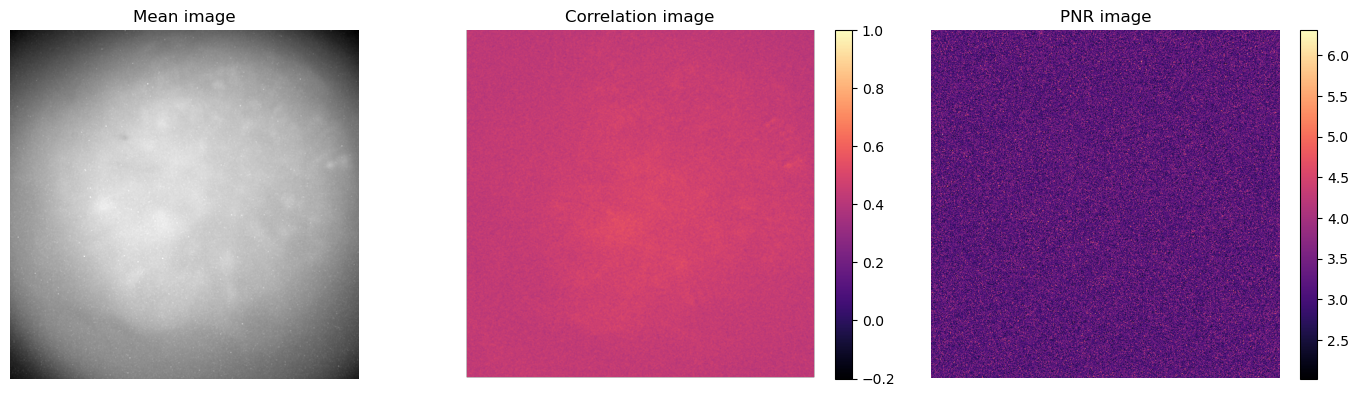

Correlation (inner)  min/max/mean: 0.35660821199417114 0.5715957283973694 0.4532022476196289
PNR min/max/mean: 2.0291876792907715 6.306585788726807 3.2211270332336426


In [2]:
# === MoS1b dF/F QC maps: correlation & PNR (OOM-safe load, RAM-friendly subset) ===
import os
import numpy as np
import matplotlib.pyplot as plt

from hybrid.io import read_tiff_stack          # OOM-safe reader (memmap/guards)
from hybrid.summary.qc_maps import correlation_image, pnr_image

# --- file to test ---
DATA_DIR = os.path.abspath("./data")
FILE_NAME = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff"
PATH = os.path.join(DATA_DIR, FILE_NAME)

# --- load movie (no hidden normalization/casting) ---
movie = read_tiff_stack(PATH, normalize_mode="none", dtype=None)
print("Loaded:", PATH, "shape:", movie.shape, "dtype:", movie.dtype)

# --- optional: reduce size for RAM safety ---
stride = 2
max_frames = 800
crop_size = 512

movie = movie[::stride]
if max_frames is not None and movie.shape[0] > max_frames:
    movie = movie[:max_frames]

def center_crop(arr, size=None):
    if size is None:
        return arr
    t, h, w = arr.shape
    hh, ww = min(size, h), min(size, w)
    y0 = max(0, h//2 - hh//2); y1 = y0 + hh
    x0 = max(0, w//2 - ww//2); x1 = x0 + ww
    return arr[:, y0:y1, x0:x1]

movie = center_crop(movie, crop_size)
print("Working subset:", movie.shape)

# --- compute QC maps (functions convert to float32 internally) ---
corr_map = correlation_image(movie, time_axis=0)               # (H, W), float32
pnr_map  = pnr_image(movie, time_axis=0, hp_window=9)          # (H, W), float32

# --- visualize ---
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].imshow(movie.mean(axis=0), cmap="gray")
axs[0].set_title("Mean image")
axs[0].axis("off")

im1 = axs[1].imshow(corr_map, vmin=-0.2, vmax=1.0, cmap="magma")
axs[1].set_title("Correlation image")
axs[1].axis("off")
fig.colorbar(im1, ax=axs[1], fraction=0.046)

im2 = axs[2].imshow(pnr_map, cmap="magma")
axs[2].set_title("PNR image")
axs[2].axis("off")
fig.colorbar(im2, ax=axs[2], fraction=0.046)

plt.tight_layout()
plt.show()

# --- numeric summary ---
inner = corr_map[1:-1, 1:-1]
print("Correlation (inner)  min/max/mean:",
      float(np.nanmin(inner)), float(np.nanmax(inner)), float(np.nanmean(inner)))
print("PNR min/max/mean:", float(pnr_map.min()), float(pnr_map.max()), float(pnr_map.mean()))


In [3]:
# === Batch QC for a folder: correlation & PNR maps (OOM-safe, RAM-friendly) ===
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from hybrid.io import read_tiff_stack          # OOM-safe reader (memmap/guards)
from hybrid.summary import correlation_image, pnr_image  # re-exports

# --- resolve data folder (prefer ./data when running from notebooks) ---
CANDIDATES = [
    os.path.abspath("./data"),                 # typical: D:\Projects\hybrid\notebooks\data
    r"D:\Projects\hybrid\notebooks\data",      # fallback absolute
]
folder = None
for p in CANDIDATES:
    if os.path.isdir(p):
        folder = p
        break
if folder is None:
    raise FileNotFoundError(
        "Can't find data folder. Tried:\n  " + "\n  ".join(CANDIDATES)
    )

out_dir = os.path.join(folder, "_qc_out")
os.makedirs(out_dir, exist_ok=True)

# --- QC parameters ---
stride = 2                   # take every Nth frame (speeds up & reduces RAM)
max_frames = 800             # None to keep all frames after stride
crop_size = 512              # center crop side (None for full frame)
hp_window = 9                # PNR high-pass window; will be made odd
skip_prefixes = ("sanity", "check_", "flat_vis")  # names to skip (case-insensitive)

def center_crop(arr, size=None):
    if size is None:
        return arr
    t, h, w = arr.shape
    hh, ww = min(size, h), min(size, w)
    y0 = max(0, h//2 - hh//2); y1 = y0 + hh
    x0 = max(0, w//2 - ww//2); x1 = x0 + ww
    return arr[:, y0:y1, x0:x1]

def list_tiffs(dir_path):
    files = []
    for name in os.listdir(dir_path):
        low = name.lower()
        if low.endswith((".tif", ".tiff")) and not low.startswith(skip_prefixes):
            files.append(name)
    return sorted(files)

def save_qc_png(base_out, mean_im, corr_map, pnr_map):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    axs[0].imshow(mean_im, cmap="gray")
    axs[0].set_title("Mean image"); axs[0].axis("off")
    im1 = axs[1].imshow(corr_map, vmin=-0.2, vmax=1.0, cmap="magma")
    axs[1].set_title("Correlation image"); axs[1].axis("off"); fig.colorbar(im1, ax=axs[1], fraction=0.046)
    im2 = axs[2].imshow(pnr_map, cmap="magma")
    axs[2].set_title("PNR image"); axs[2].axis("off"); fig.colorbar(im2, ax=axs[2], fraction=0.046)
    plt.tight_layout()
    png_path = base_out + "_qc.png"
    plt.savefig(png_path, dpi=150)
    plt.close(fig)
    return png_path

def make_odd(n: int) -> int:
    return n if (n % 2 == 1) else (n + 1)

print("Data folder:", folder)
files = list_tiffs(folder)
print("Found TIFFs:", len(files))
hp_window = make_odd(int(hp_window))

for i, fname in enumerate(files, 1):
    path = os.path.join(folder, fname)
    print(f"[{i}/{len(files)}] {fname}")
    t0 = time.time()
    try:
        # OOM-safe load (memmap if possible), без скрытой нормализации/каста
        movie = read_tiff_stack(path, normalize_mode="none", dtype=None)

        # лёгкое downsample по времени и ограничение длины
        movie = movie[::stride]
        if max_frames is not None and movie.shape[0] > max_frames:
            movie = movie[:max_frames]

        # центр-кроп для экономии памяти/времени
        movie = center_crop(movie, crop_size)

        # QC maps (функции сами приводят к float32)
        corr_map = correlation_image(movie, time_axis=0)
        pnr_map  = pnr_image(movie, time_axis=0, hp_window=hp_window)

        # save outputs рядом с данными
        base = os.path.join(out_dir, os.path.splitext(fname)[0])
        png_path = save_qc_png(base, movie.mean(axis=0), corr_map, pnr_map)
        np.save(base + "_corr.npy", corr_map.astype(np.float32, copy=False))
        np.save(base + "_pnr.npy",  pnr_map.astype(np.float32, copy=False))

        dt = time.time() - t0
        print(f"  -> saved {png_path} | subset={tuple(movie.shape)} | time={dt:.1f}s")

    except Exception as e:
        print(f"  !! skipped due to error: {e}")


Data folder: D:\Projects\hybrid\notebooks\data
Found TIFFs: 15
[1/15] MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
  -> saved D:\Projects\hybrid\notebooks\data\_qc_out\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_qc.png | subset=(800, 512, 512) | time=88.7s
[2/15] MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_f32.tiff
[I/O] Using memmap: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_f32.tiff
  -> saved D:\Projects\hybrid\notebooks\data\_qc_out\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_f32_qc.png | subset=(800, 512, 512) | time=85.5s
[3/15] MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_u16.tiff
[I/O] Using memmap: D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_u16.tiff
  -> saved D:\Projects\hybrid\notebooks\data\_qc_out\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_baseline_u16_qc.png | subset=(800, 512, 512) | time=76.1s
[4/15] MoS1b_s1_C1_M1_T1_FL2_2025_

### cli/mc_cli check

In [1]:
# Test: mc_cli.run_mc on a single TIFF (run from D:\Projects\hybrid\notebooks)
import os

from hybrid.cli.mc_cli import run_mc
from hybrid.io import read_tiff_stack  # public import point

DATA_DIR = os.path.abspath("./data")
IN_FILE  = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"

in_path = os.path.join(DATA_DIR, IN_FILE)
out_dir = os.path.join(DATA_DIR, "_mc_test")
os.makedirs(out_dir, exist_ok=True)

# Run motion correction (GPU/CPU auto)
run_mc(
    path=in_path,
    outdir=out_dir,
    tiles=(4, 4),
    overlap=32,
    upsample=10,
    device="auto",
    use_dog=False,    # DoG only if реально нужно
    stride=1,
    max_frames=None,  # None = keep all frames
    # compress=False, # <- если такой флаг есть в run_mc, сделает выход memmap-friendly
)

# Check outputs
produced = [f for f in os.listdir(out_dir) if f.endswith("_pwrigid_f32.tiff")]
print("Produced:", produced)

# Sanity read (reader сам выберет memmap/RAM/staging)
if produced:
    pw_path = os.path.join(out_dir, produced[0])
    movie = read_tiff_stack(pw_path, normalize_mode="none", dtype=None)
    print("PW shape:", movie.shape, "dtype:", movie.dtype)
else:
    print("No *_pwrigid_f32.tiff produced.")


[I/O] Using full-RAM imread (~2.23 GiB): D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff
[GPU-auto] CuPy available → using GPU backend for pw-rigid
pw-rigid MC (GPU): 100%|███████████████████████████████████████████████████████████| 1951/1951 [02:40<00:00, 12.12it/s]
[OK] D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff -> D:\Projects\hybrid\notebooks\data\_mc_test\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff | mean_corr_after=0.9948
Produced: ['MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff']
[I/O] Using memmap: D:\Projects\hybrid\notebooks\data\_mc_test\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff
PW shape: (1951, 800, 768) dtype: float32


### cli/prep_cli check

In [5]:
# Test: prep_cli.run_prep on a single TIFF (run from D:\Projects\hybrid\notebooks)
import os

from hybrid.cli.prep_cli import run_prep           # you can also use: from hybrid.cli import run_prep
from hybrid.io import read_tiff_stack                  # public import point

# Paths (relative to notebooks/)
DATA_DIR = os.path.abspath("./data")
IN_FILE  = "MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff"

in_path = os.path.join(DATA_DIR, IN_FILE)
out_dir = os.path.abspath("./data/_prep_test")         # keep outputs alongside data
os.makedirs(out_dir, exist_ok=True)

run_prep(
    path=in_path,
    outdir=out_dir,
    # flat-field
    flat_sigma=60,            # int; set to None to skip
    save_flat=True,
    save_ff=True,
    # detrend
    detrend_sigma=100.0,      # float; set to None to skip
    save_detrended=True,
    # dF/F
    dff_pct=10.0,             # float; set to None to skip
    dff_win=301,
    save_dff=True,
    # performance
    stride=1,
    max_frames=0,             # 0 = keep all frames after stride
    chunk=64,
    gpu_halo=0,
)

print("Outputs (top 10):", sorted(os.listdir(out_dir))[:10])

# Optional: peek one dF/F result
dff_candidates = [f for f in os.listdir(out_dir) if "_dff_" in f and f.endswith(".tiff")]
if dff_candidates:
    dff_path = os.path.join(out_dir, dff_candidates[0])
    dff_movie = read_tiff_stack(dff_path, normalize_mode="none", ram_budget_bytes=None, dtype=None)
    print("dF/F shape:", dff_movie.shape)
else:
    print("No dF/F output found.")


[flat] sigma=60
  -> saved D:\Projects\hybrid\notebooks\data\_prep_test\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_flat_f32.tiff
  -> saved D:\Projects\hybrid\notebooks\data\_prep_test\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_ff_f32.tiff
[detrend] sigma_t=100.0 | chunk=64
detrend·subtract: 100%|███████████████████████████████████████████████████████████| 1951/1951 [00:10<00:00, 187.10fr/s]
  -> saved D:\Projects\hybrid\notebooks\data\_prep_test\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_detrended_f32.tiff
[dF/F] pct=10.0 win=301 | chunk=64
[GPU] dFF (percentile)  win=301  chunk=64  block=364: 100%|████████████████████████████| 31/31 [01:13<00:00,  2.38s/it]
  -> saved D:\Projects\hybrid\notebooks\data\_prep_test\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_dff_p10_w301_f32.tiff
[OK] D:\Projects\hybrid\notebooks\data\MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff
Outputs (top 10): ['MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_detrended_f32.tiff', 'MoS1b_s1_C1_M1_T1_FL2_2025_

### cli/qc_cli check

In [5]:
# Test: qc_cli.run_qc on a single TIFF to produce QC outputs and stats
import os
from hybrid.cli.qc_cli import run_qc

in_path = r"./_mc_test/MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff"
out_dir = r"./_qc_test"

stats = run_qc(
    path=in_path,
    outdir=out_dir,
    stride=2,        # take every 2nd frame to speed up QC
    max_frames=800,
    crop=512,        # center crop for speed (None -> full size)
    hp_window=15
)
print("QC stats:", stats)
print("QC files in dir:", sorted(os.listdir(out_dir))[:10])


QC stats: {'file': 'MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff', 'T': 800, 'H': 512, 'W': 512, 'corr_mean': 0.4531998336315155, 'corr_p95': 0.4990888833999634, 'pnr_median': 3.178790807723999, 'pnr_p95': 3.9335734844207764, 'png': 'MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_qc.png'}
QC files in dir: ['MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_corr.npy', 'MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_pnr.npy', 'MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32_qc.png']


### summary/viz check

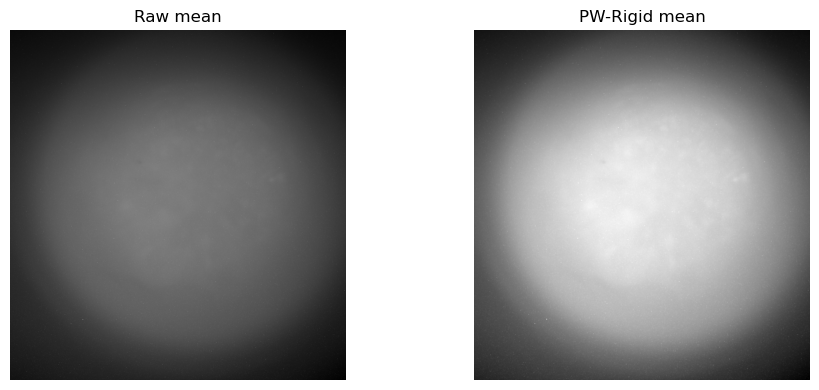

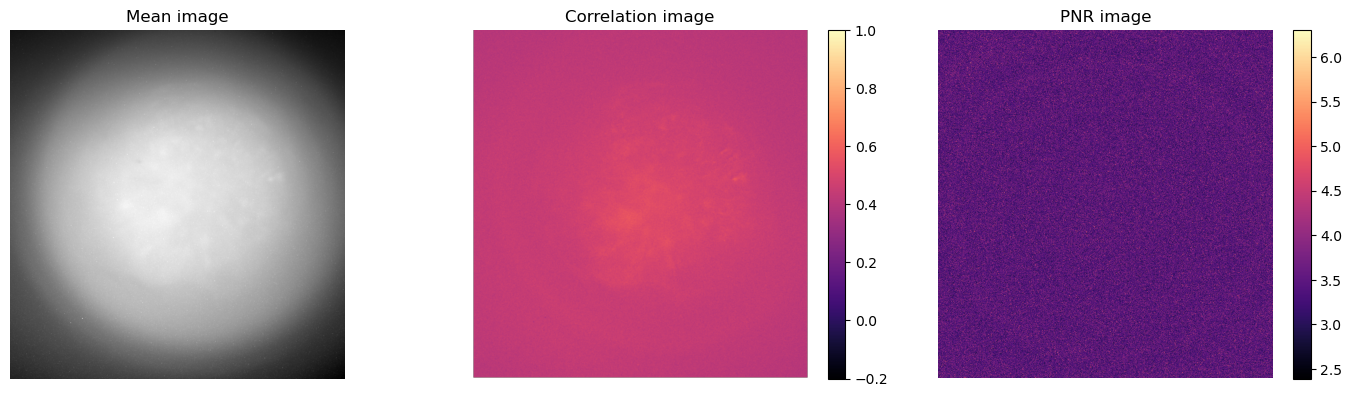

In [6]:
# Quick visualization helpers
import matplotlib.pyplot as plt
import numpy as np
from hybrid.io.tif import read_tiff_stack
from hybrid.summary.qc_maps import correlation_image, pnr_image
from hybrid.summary.viz import show_qc_maps, grid_before_after

# load any two movies to compare
raw_path = r"MoS1b_s1_C1_M1_T1_FL2_2025_04_08.tiff"
mc_path  = r"./_mc_test/MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff"

raw = read_tiff_stack(raw_path, normalize=False, dtype=np.float32)
mc  = read_tiff_stack(mc_path,  normalize=False, dtype=np.float32)

# 4.1 Before/After (mean frames)
fig = grid_before_after(raw.mean(axis=0), mc.mean(axis=0), titles=("Raw mean", "PW-Rigid mean"))
plt.show()

# 4.2 QC three-panel for the MC movie
corr_map = correlation_image(mc)
pnr_map  = pnr_image(mc, hp_window=15)
fig = show_qc_maps(mc.mean(axis=0), corr_map, pnr_map)
plt.show()


In [1]:
# Test qc_cli.process_one with normalization modes
from hybrid.cli.qc_cli import process_one

stats_none = process_one(
    path=r"./_mc_test/MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff",
    outdir=r"./_qc_test_norm",
    stride=2, max_frames=800, crop=512,
    hp_window=15,
    norm_mode="none", p_low=1.0, p_high=99.5,
)
print("NONE:", stats_none["corr_mean"], stats_none["pnr_p95"])

stats_pct = process_one(
    path=r"./_mc_test/MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff",
    outdir=r"./_qc_test_norm",
    stride=2, max_frames=800, crop=512,
    hp_window=15,
    norm_mode="percentile", p_low=1.0, p_high=99.5,
)
print("PERCENTILE:", stats_pct["corr_mean"], stats_pct["pnr_p95"])


NONE: 0.4531998336315155 3.9335734844207764
PERCENTILE: 0.45124518871307373 3.8484151363372803


### cellpose check

Python: 3.10.18 | OS: Windows-10-10.0.26100-SP0
Torch: 2.3.1 | CUDA avail: True | CUDA: 11.8
OpenCV: 4.10.0
Cellpose: 4.0.6
Cellpose will use GPU: True


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Masks: (800, 768) n_labels: 0


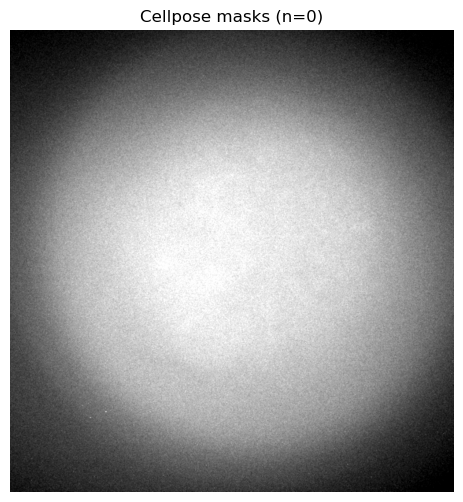

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch, cv2, sys, platform
from cellpose import models, core
from hybrid.io.tif import read_tiff_stack

# --- versions / sanity ---
print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("Torch:", torch.__version__, "| CUDA avail:", torch.cuda.is_available(), "| CUDA:", torch.version.cuda)
print("OpenCV:", cv2.__version__)
try:
    import importlib.metadata as im
    print("Cellpose:", im.version("cellpose"))
except Exception:
    pass

use_gpu = core.use_gpu()
print("Cellpose will use GPU:", use_gpu)

# --- data ---
path = r"./_mc_test/MoS1b_s1_C1_M1_T1_FL2_2025_04_08_pwrigid_f32.tiff"
norm_mode, p_low, p_high = "percentile", 1.0, 99.0

movie = read_tiff_stack(path, normalize=False, p_low=p_low, p_high=p_high,
                        dtype=np.float32, normalize_mode=norm_mode)
frame = movie[movie.shape[0]//2].astype(np.float32, copy=False)

if norm_mode == "none":
    lo, hi = np.percentile(frame, 1.0), np.percentile(frame, 99.0)
    f = np.clip((frame - lo) / (hi - lo + 1e-6), 0, 1).astype(np.float32, copy=False)
else:
    f = np.clip(frame, 0, 1)

# --- run Cellpose (v4.x API) ---
# model_type игнорируется в 4.x; используем дефолтные веса (эквивалент cyto2)
model = models.CellposeModel(gpu=use_gpu)  # можно добавить device="cuda"

# В 4.x eval НЕ принимает net_avg. Минимальный вызов:
# - передаем список изображений [f]
# - channels=[0,0] для grayscale
masks, flows, styles = model.eval([f], channels=[0, 0], diameter=None)

masks = masks[0]
print("Masks:", masks.shape, "n_labels:", int(masks.max()))

# --- visualize ---
plt.figure(figsize=(6,6))
plt.imshow(f, cmap="gray")
plt.contour(masks, colors="r", linewidths=0.5)
plt.title(f"Cellpose masks (n={int(masks.max())})")
plt.axis("off")
plt.show()
